# **House Prices Advanced Regression Project Team 1**

In [1]:
try:
    import shap
    import numpy as np 
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns





In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **A) Data Loading and Inspection**

In [4]:
try:
    train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
    test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
except FileNotFoundError:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

In [5]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [10]:

summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Rows": [train_df.shape[0], test_df.shape[0]],
    "Columns": [train_df.shape[1], test_df.shape[1]],
    "Missing Values": [train_df.isnull().sum().sum(), test_df.isnull().sum().sum()]
})

display(summary)

,Dataset,Rows,Columns,Missing Values
0,Train,1460,81,7829
1,Test,1459,80,7878


In [11]:
print("Duplicated records in train set:", train_df.duplicated().sum())
print("Duplicated records in test set:", test_df.duplicated().sum())

Duplicated records in train set: 0
Duplicated records in test set: 0


# **B) EDA (Exploratory Data Analysis)**

**1. Target Analysis (SalePrice)**

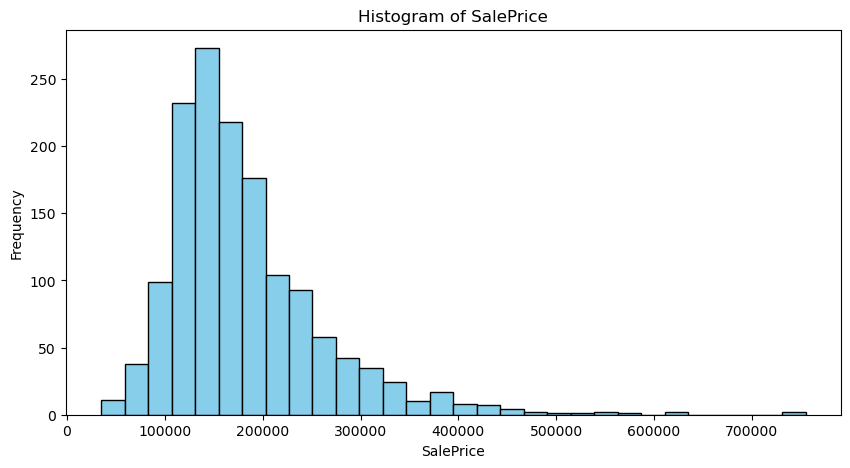

In [12]:
# a. Histogram of SalePrice
plt.figure(figsize=(10,5))
plt.hist(train_df['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

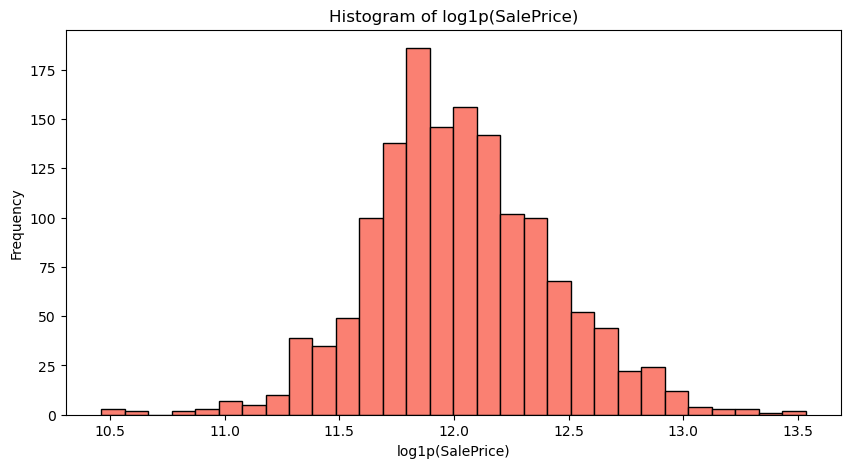

In [13]:
# b. Histogram of log1p(SalePrice)
plt.figure(figsize=(10,5))
plt.hist(np.log1p(train_df['SalePrice']), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')
plt.ylabel('Frequency')
plt.show()

In [14]:
# c. Skewness Check
print("SalePrice Skewness:", train_df['SalePrice'].skew())
print("log1p(SalePrice) Skewness:", np.log1p(train_df['SalePrice']).skew())

SalePrice Skewness: 1.8828757597682129
log1p(SalePrice) Skewness: 0.12134661989685333


**2. Missing Value Analysis**

              MissingCount  MissingPercent
PoolQC                1453       99.520548
MiscFeature           1406       96.301370
Alley                 1369       93.767123
Fence                 1179       80.753425
MasVnrType             872       59.726027
FireplaceQu            690       47.260274
LotFrontage            259       17.739726
GarageType              81        5.547945
GarageYrBlt             81        5.547945
GarageFinish            81        5.547945
GarageQual              81        5.547945
GarageCond              81        5.547945
BsmtFinType2            38        2.602740
BsmtExposure            38        2.602740
BsmtFinType1            37        2.534247
BsmtCond                37        2.534247
BsmtQual                37        2.534247
MasVnrArea               8        0.547945
Electrical               1        0.068493


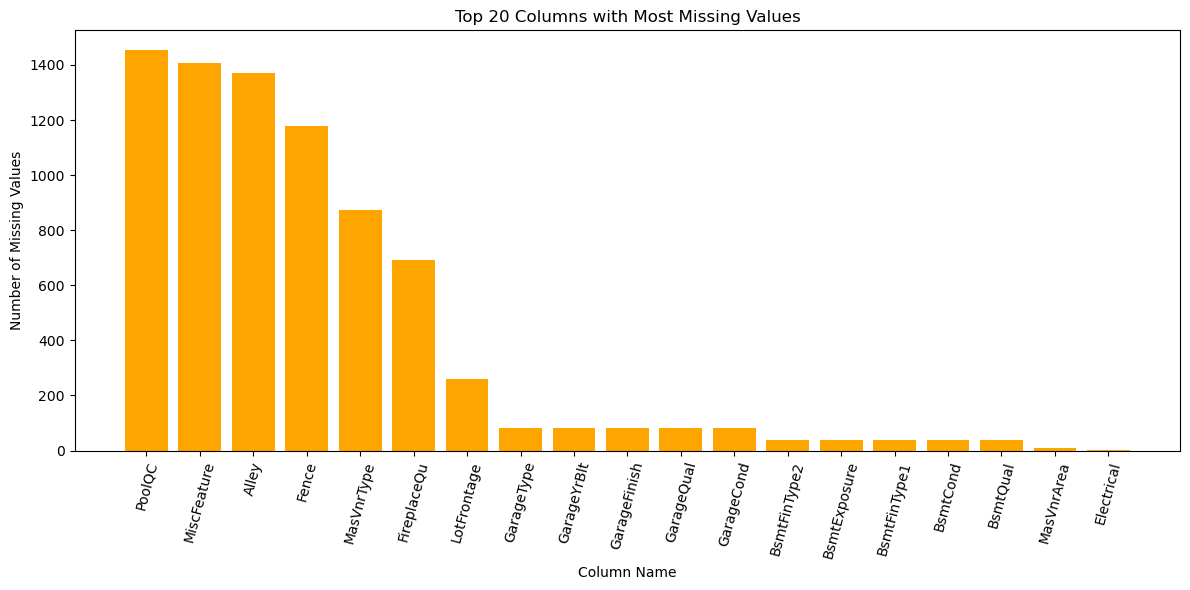

In [15]:
# 1. Her sütundaki eksik değer sayısını bul
missing_counts = train_df.isnull().sum()

# 2. Eksik değeri olan sütunları ve oranlarını bul, en çok eksik olan ilk 20 sütunu seç
missing_percent = (missing_counts / len(train_df)) * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPercent': missing_percent
})
missing_df = missing_df[missing_df['MissingCount'] > 0]
missing_df = missing_df.sort_values(by='MissingCount', ascending=False).head(20)

# 3. Sonuçları yazdır
print(missing_df)

# 4. Bar plot ile görselleştir
plt.figure(figsize=(12,6))
plt.bar(missing_df.index, missing_df['MissingCount'], color='orange')
plt.xticks(rotation=75)
plt.title('Top 20 Columns with Most Missing Values')
plt.ylabel('Number of Missing Values')
plt.xlabel('Column Name')
plt.tight_layout()
plt.show()

**3. Correlation Analysis (Numerical)**

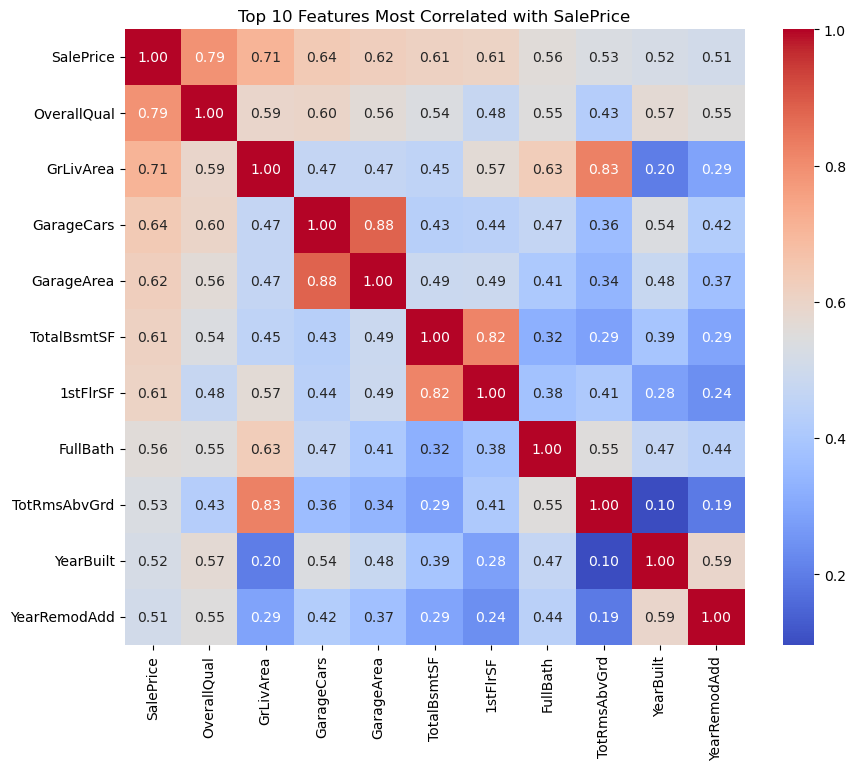

In [16]:


# Sadece sayısal sütunları seç
numeric_cols = train_df.select_dtypes(include=['number'])

# Korelasyon matrisini hesapla
corr_matrix = numeric_cols.corr()

# SalePrice ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index  # 11 çünkü SalePrice kendisi de dahil

# Bu özelliklerin korelasyon matrisini al
top_corr_matrix = corr_matrix.loc[top_corr_features, top_corr_features]

# Isı haritası çiz
plt.figure(figsize=(10,8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Features Most Correlated with SalePrice')
plt.show()

**4. Feature vs. SalePrice Visualizations**

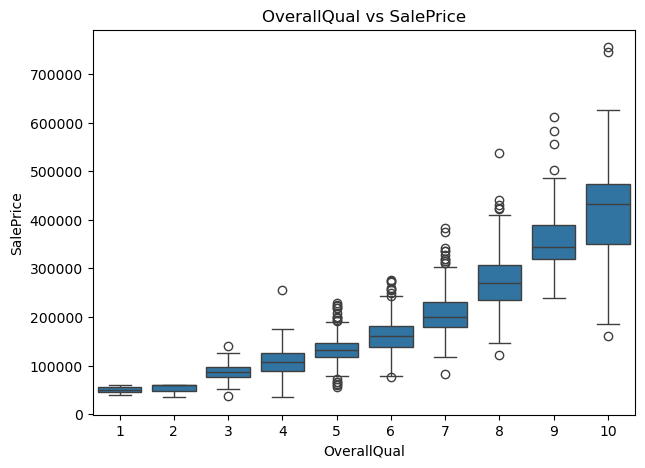

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


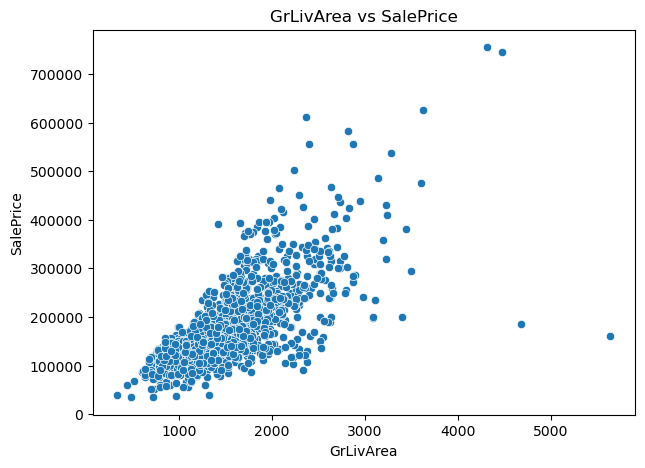

Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.


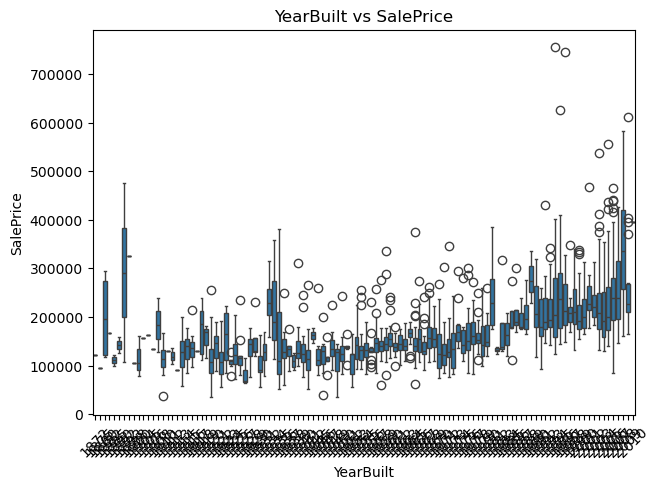

Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.


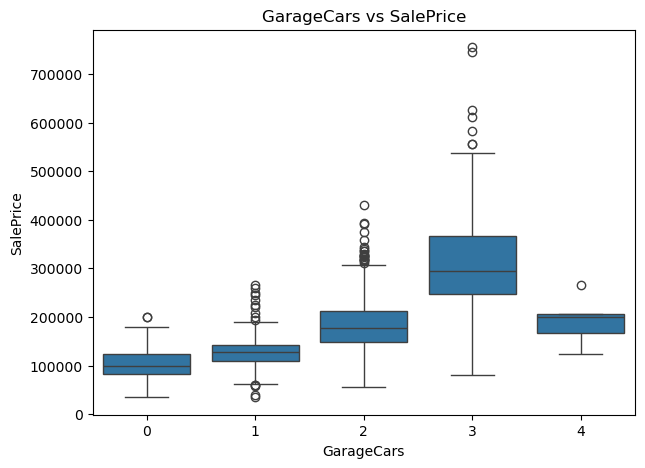

Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.


In [17]:
# 1. OverallQual vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('OverallQual vs SalePrice')
plt.show()
print("Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.")

# 2. GrLivArea vs SalePrice
plt.figure(figsize=(7,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('GrLivArea vs SalePrice')
plt.show()
print("Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.")

# 3. YearBuilt vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.title('YearBuilt vs SalePrice')
plt.show()
print("Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.")

# 4. GarageCars vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.title('GarageCars vs SalePrice')
plt.show()
print("Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.")

**C) Data Cleaning**

In [18]:
# 1. Numerical columns: Fill missing values with median
num_cols = train_df.select_dtypes(include=['number']).columns
for col in num_cols:
    median = train_df[col].median()
    train_df[col].fillna(median, inplace=True)
    if col in test_df.columns:
        test_df[col].fillna(median, inplace=True)

# 2. Categorical columns: Fill missing values with 'None' or most frequent
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu']:
        train_df[col].fillna('None', inplace=True)
        if col in test_df.columns:
            test_df[col].fillna('None', inplace=True)
    else:
        mode = train_df[col].mode()[0]
        train_df[col].fillna(mode, inplace=True)
        if col in test_df.columns:
            test_df[col].fillna(mode, inplace=True)

C:\Users\abdul\AppData\Local\Temp\ipykernel_23572\3654212499.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(median, inplace=True)
C:\Users\abdul\AppData\Local\Temp\ipykernel_23572\3654212499.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 